## load data

In [1]:
dataset_path = "Topic_data/topic_data.csv"

In [2]:
from datasets import load_dataset
import datasets
import csv
# from PIL import Image
import numpy as np
from datasets import Dataset, Image

def load_data(data_path):
    csv_data_list = []
    with open(data_path, encoding="UTF-8") as f:
        reader = csv.reader(f)
        header_row = next(reader)
        # print(header_row)

        for row in reader:
            csv_data_list.append(row)

    # imgs = []
    label_ids = []
    labels = []
    path_label_dict = {}
    dataset_dict = {'img': [], 'label_id': []}  # "image": path,

    for row in csv_data_list:
        img_path = "data/" + row[0]
        label_id = row[1]
        # label_ids.append(label_id)
        dataset_dict['label_id'].append(int(label_id))

        label_name = row[2]
        # labels.append(label_name)

        # img_file = Image.open(img_path)
        # img_array = np.array(img_file)
        dataset_dict['img'].append(img_path)



        path_label_dict[img_path] = label_id
        # print(img_array.shape)

    return_dataset = Dataset.from_dict(dataset_dict).cast_column("img", Image())

    return return_dataset

whole_set = load_data(dataset_path)
splits = whole_set.train_test_split(test_size=0.2)
train_val_set = splits['train']
test_set = splits['test']
splits = train_val_set.train_test_split(test_size=0.25)
train_set = splits['train']
val_set = splits['test']

# print(len(whole_set))
# print(len(train_set))
# print(len(val_set))
# print(len(test_set))
print(train_set.features)

{'img': Image(decode=True, id=None), 'label_id': Value(dtype='int64', id=None)}


In [3]:
print(type(train_set['label_id']))

<class 'list'>


## Preprocessing

In [4]:
from transformers import ViTImageProcessor, BeitImageProcessor

processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')

In [5]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size
# size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
transform_train = Compose(
        [
            Resize([size["height"], size["width"]]),
            # RandomResizedCrop(size),
            # RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

transform_val = Compose(
        [
            Resize([size["height"], size["width"]]),
            # CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [transform_train(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [transform_val(image.convert("RGB")) for image in examples['img']]
    return examples

In [6]:
# print(size)

In [7]:
train_set.set_transform(train_transforms)
val_set.set_transform(val_transforms)
test_set.set_transform(val_transforms)

## Define the model

In [8]:
from transformers import BeitForImageClassification

model = BeitForImageClassification.from_pretrained\
    ('microsoft/beit-base-patch16-224',
     # id2label=id2label,
     # label2id=label2id,
     ignore_mismatched_sizes=True)

model = model.cuda()

In [9]:
import torch
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # labels = torch.tensor([example["label"] for example in examples])
    labels = torch.tensor([example["label_id"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [10]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"checkpoints",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=20, # 10
    per_device_eval_batch_size=10, # 4
    num_train_epochs=3, # 3
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [11]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [12]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Train model

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss


C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (112480000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (141750000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (141750000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (112480000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\

TrainOutput(global_step=5790, training_loss=1.4240018116583684, metrics={'train_runtime': 5139.4, 'train_samples_per_second': 22.529, 'train_steps_per_second': 1.127, 'total_flos': 9.04883114446037e+18, 'train_loss': 1.4240018116583684, 'epoch': 3.0})

In [14]:
test_outputs = trainer.predict(test_set)

acurracy 0.6111154294597746
precision 0.334690392946526
recall 0.29282462060838776
f1_score 0.2992843366046468


C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gao\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: unsupported format string passed to Value.__format__

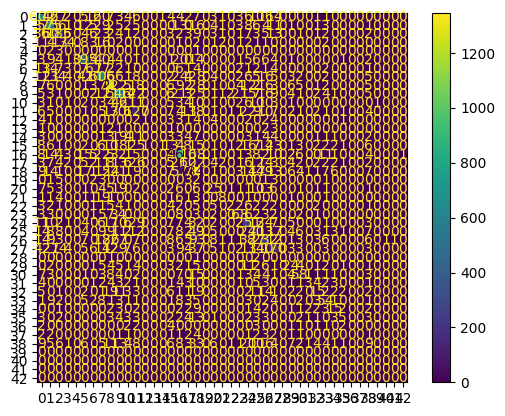

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

print("acurracy", accuracy_score(y_true, y_pred))
print("precision", precision_score(y_true, y_pred, average='macro'))
print("recall", recall_score(y_true, y_pred, average='macro'))
print("f1_score", f1_score(y_true, y_pred, average='macro'))



# labels = test_set.features['label'].names
labels = test_set.features['label_id']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)